In [1]:
import pandas as pd

from matplotlib import pyplot as plt
from matplotlib import animation

import fastf1
import fastf1.plotting

# Setup Basics

In [2]:
fastf1.Cache.enable_cache('./cache')
fastf1.plotting.setup_mpl()

In [3]:
# load a session and its telemetry data
session = fastf1.get_session(2022, 'Monaco Grand Prix', 'R')
session.load()

core           INFO 	Loading data for Monaco Grand Prix - Race [v2.2.5]
api            INFO 	Using cached data for driver_info
api            INFO 	Using cached data for timing_data
api            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
api            INFO 	Using cached data for session_status_data
c:\Users\hhalp\.datasci\lib\site-packages\fastf1\core.py:1261: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result = result.append(new_last).reset_index(drop=True)
api            INFO 	Using cached data for track_status_data
api            INFO 	Using cached data for car_data
api            INFO 	Using cached data for position_data
api            INFO 	Using cached data for weather_data
api            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['11', '55', '1', '16', '63', '4', '14', '44'

In [4]:
# choose some colors with good contrast for the drivers
colors = plt.get_cmap('tab20')
driver_colors = {
    'VER': colors(0),
    'PER': colors(1),
    'LEC': colors(6),
    'SAI': colors(7),
    'NOR': colors(2),
    'LAT': colors(8)
}

# Create Some Useful Functions

In [5]:
def get_map_values(drivers, lap_nums):
    tel = [session.laps[(session.laps.Driver == d) & (session.laps.LapNumber.isin(lap_nums))].get_telemetry() for d in drivers]
    start_date = max(t.Date.iloc[0] for t in tel)
    end_date = min(t.Date.iloc[-1] for t in tel)
    return [t[(t.Date >= start_date) & (t.Date <= end_date)] for t in tel]

In [6]:
def replace_data(orig_df, orig_start=None, orig_end=None, replace_df=None, replace_start=None, replace_end=None):
    if orig_start is None:
        orig_start = orig_df.SessionTime.iloc[0]
    if orig_end is None:
        orig_end = orig_df.SessionTime.iloc[-1]
    if replace_df is None:
        replace_start, replace_end = pd.Timedelta(seconds=0), pd.Timedelta(seconds=0)
    if replace_start is None:
        replace_start = replace_df.SessionTime.iloc[0]
    if replace_end is None:
        replace_end = replace_df.SessionTime.iloc[-1]

    first_part = orig_df[orig_df.SessionTime < orig_start]
    if replace_df is not None:
        middle_part = replace_df[(replace_df.SessionTime >= replace_start) 
                                 & (replace_df.SessionTime <= replace_end)].copy(deep=True)
        middle_adj = (replace_start - orig_start)
        middle_part.loc[:, ('Date', 'SessionTime', 'Time')] -= middle_adj
    else:
        middle_part = fastf1.core.Telemetry()
    last_part = orig_df[orig_df.SessionTime > orig_end].copy(deep=True)
    last_adj = replace_end - replace_start - orig_end + orig_start
    last_part.loc[:, ('Date', 'SessionTime', 'Time')] += last_adj

    return pd.concat([first_part, middle_part, last_part], ignore_index=True)


# Get/Create The Data For the Simulation

In [7]:
ds =  ['SAI', 'PER', 'NOR', 'LEC', 'VER']
map_vals = get_map_values(ds, range(16, 20))

In [8]:
lec_s2_before = session.laps.loc[(session.laps.Driver == 'LEC') & (session.laps.LapNumber == 18), 'Sector2SessionTime'].iloc[0]
lec_s2_after = session.laps.loc[(session.laps.Driver == 'LEC') & (session.laps.LapNumber == 19), 'Sector2SessionTime'].iloc[0]
sai_s2_before = session.laps.loc[(session.laps.Driver == 'SAI') & (session.laps.LapNumber == 17), 'Sector2SessionTime'].iloc[0]
sai_s2_after = session.laps.loc[(session.laps.Driver == 'SAI') & (session.laps.LapNumber == 18), 'Sector2SessionTime'].iloc[0]

In [9]:
lec_replace = map_vals[3][(map_vals[3].SessionTime >= lec_s2_before) & (map_vals[3].SessionTime <= lec_s2_after)].copy(deep=True)

## Replace Leclerc's Bad Pit with Sainz'

In [10]:
sai_pit_in = session.laps.loc[(session.laps.Driver == 'SAI') & (session.laps.LapNumber == 21), ('PitInTime')].iloc[0]
sai_pit_out = session.laps.loc[(session.laps.Driver == 'SAI') & (session.laps.LapNumber == 22), ('PitOutTime')].iloc[0]
lec_pit_in = session.laps.loc[(session.laps.Driver == 'LEC') & (session.laps.LapNumber == 18), ('PitInTime')].iloc[0]
lec_pit_out = session.laps.loc[(session.laps.Driver == 'LEC') & (session.laps.LapNumber == 19), ('PitOutTime')].iloc[0]

In [11]:
saireplace = get_map_values(['SAI'], [21, 22])[0]
new_lec_replace = replace_data(lec_replace, lec_pit_in, lec_pit_out, saireplace, sai_pit_in, sai_pit_out)
new_lec_s2 = lec_s2_after + (new_lec_replace.SessionTime.iloc[-1] - lec_replace.SessionTime.iloc[-1])

## Replace Sainz' End of Lap with Leclerc's

In [12]:
map_vals[0] = replace_data(map_vals[0], sai_s2_before, sai_s2_after, new_lec_replace, lec_s2_before, new_lec_s2)

# Setup Map For Plotting

In [13]:
# Get a full lap without pitstops to plot a good track line
map_coords = session.laps[(session.laps.Driver == 'SAI') & (session.laps.LapNumber == 19)].get_telemetry()[['X', 'Y', 'RelativeDistance']]

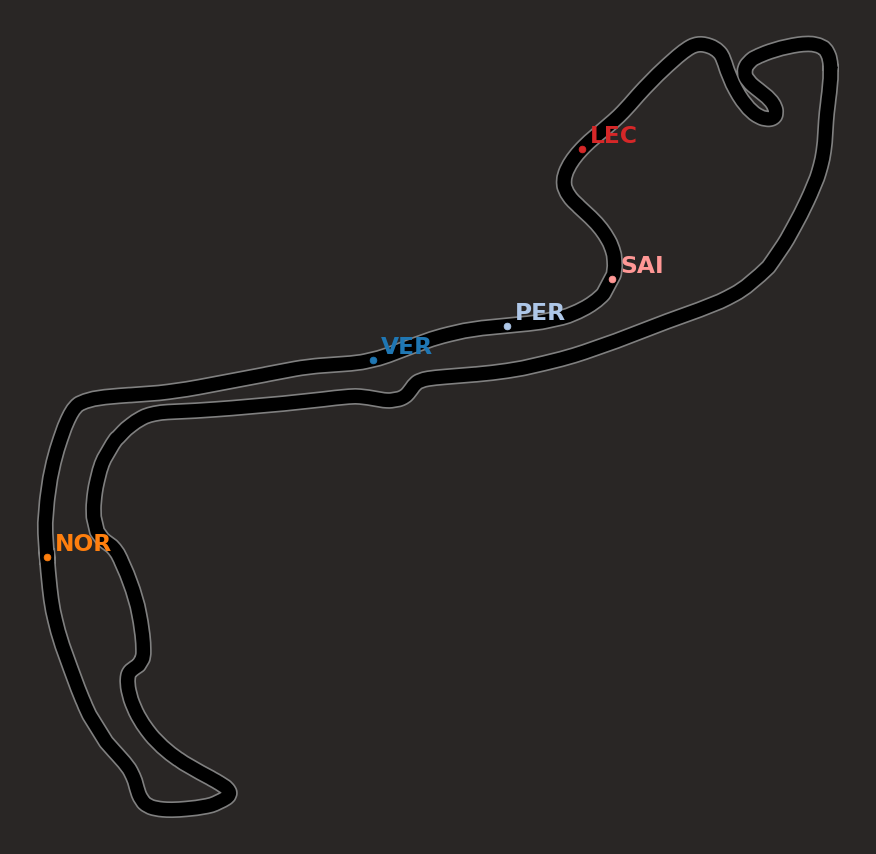

In [14]:
# create basic figure, don't show axes
fig, ax = plt.subplots(sharex=True, sharey=True, figsize=(18, 18), dpi=60)
plt.subplots_adjust(left=0.1, right=0.9, top=0.9, bottom=0.12)
ax.axis('off')

# plot track line (grey is to make the lighter outline for easier visuals)
ax.plot(map_coords.X, map_coords.Y, color='grey', linestyle='-', linewidth=20, zorder=0)
ax.plot(map_coords.X, map_coords.Y, color='black', linestyle='-', linewidth=16, zorder=0)

# plot initial points & text, to be modified for the animation
lines, texts = [], []
for i, d in enumerate(ds):
    dc = driver_colors[d]
    x, y = map_vals[i].X.iloc[0], map_vals[i].Y.iloc[0]
    texts.append(ax.text(x+75, y+75, d, color=dc, fontsize=28, fontweight='bold'))
    line, = ax.plot(x, y, marker='o', color=dc, markersize=8)
    lines.append(line)

In [15]:
# resample each section of values to 1/8 of a second for syncronized plotting
# record the minimum length to use for the number of frames
min_len = float('inf')
for i in range(len(map_vals)):
    map_vals[i] = map_vals[i].resample_channels(pd.Timedelta(seconds=0.125))
    min_len = min(min_len, len(map_vals[i]))

# Create the Animation

In [16]:
# initialization function: plot the background of each frame
def init():
    for l in lines:
        l.set_data([], [])
    return lines

# animation function.  This is called sequentially
def animate(i):
    # set each new position for the point & text
    for v, l, t in zip(map_vals, lines, texts):
        l.set_data(v.X.iloc[i], v.Y.iloc[i])
        t.set_position((v.X.iloc[i] + 75, v.Y.iloc[i] + 75))
    return lines + texts

# call the animator.  blit=True means only re-draw the parts that have changed.
anim = animation.FuncAnimation(fig, animate, init_func=init,
                               frames=min_len, interval=20, blit=True)

In [17]:
writermpeg = animation.FFMpegWriter(fps=64)
anim.save('saidropoff.mp4', writer=writermpeg)

animation       INFO 	Animation.save using <class 'matplotlib.animation.FFMpegWriter'>
animation       INFO 	MovieWriter._run: running command: ffmpeg -f rawvideo -vcodec rawvideo -s 1080x1080 -pix_fmt rgba -r 64 -loglevel error -i pipe: -vcodec h264 -pix_fmt yuv420p -y saidropoff.mp4
